In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mplfinance as mpf
import talib as ta

In [11]:
Catcolors = {
    "rosewater": "#f5e0dc",
    "flamingo":  "#f2cdcd",
    "pink":      "#f5c2e7",
    "mauve":     "#cba6f7",
    "red":       "#f38ba8",
    "maroon":    "#eba0ac",
    "peach":     "#fab387",
    "yellow":    "#f9e2af",
    "green":     "#a6e3a1",
    "teal":      "#94e2d5",
    "sky":       "#89dceb",
    "blue":      "#74c7ec",
    "lavender":  "#b4befe",
    "text":      "#cdd6f4",
    "subtext1":  "#bac2de",
    "subtext0":  "#a6adc8",
    "surface0":  "#1e1e2e",
    "surface1":  "#313244",
    "surface2":  "#45475a",
}

Chartinfos = {
    "interval": 15,
    "title" : "Chart for 15MIN interval"
}

# printthis = f"lorem ipsum dollar {Chartinfos['interval']}"

# print(printthis)

In [12]:
# Load the MT5 CSV
df = pd.read_csv( "xauusdm15.filtered.csv" )

# Set DateTime as index
df['DateTime'] = pd.to_datetime(df["DateTime"])
df.set_index("DateTime", inplace=True)

# Optional: keep only OHLC + Volume for plotting
ohlc_df = df[["Open", "High", "Low", "Close", "Volume"]]

print(ohlc_df.head())

                         Open      High       Low     Close  Volume
DateTime                                                           
2024-01-01 23:00:00  2064.593  2066.092  2063.301  2065.142      10
2024-01-01 23:15:00  2065.159  2065.900  2064.443  2064.698      15
2024-01-01 23:30:00  2064.664  2065.131  2063.634  2064.258      15
2024-01-01 23:45:00  2064.259  2064.259  2062.643  2063.543      14
2024-01-02 00:00:00  2063.347  2064.932  2063.331  2064.006      15


In [13]:
plot_data = ohlc_df.tail(300).copy()
plot_data = plot_data.reset_index()

# Compute RSI
plot_data['RSI'] = ta.RSI(plot_data['Close'], timeperiod=14)

# Compute EMA on RSI
plot_data['RSI_EMA21'] = ta.EMA(plot_data['RSI'], timeperiod=21)

# You can still compute price EMAs if needed
plot_data['EMA21'] = ta.EMA(plot_data['Close'], timeperiod=21)
plot_data['EMA51'] = ta.EMA(plot_data['Close'], timeperiod=51)

# Difference of price EMAs
plot_data['Diff'] = plot_data['EMA21'] - plot_data['EMA51']
plot_data['CrossSignal'] = plot_data['Diff'].apply(np.sign).diff()
plot_data['CrossSignal'] = plot_data['CrossSignal'].map({2: 1, -2: -1}).fillna(0)

# Trim initial rows
Strat_from = 30
plot_data = plot_data.iloc[Strat_from:]

# Show last 3 rows
print(plot_data.iloc[:, 6:].tail(3))

           RSI  RSI_EMA21        EMA21        EMA51      Diff  CrossSignal
297  56.233516  58.512771  2623.058261  2619.374373  3.683888          0.0
298  57.776547  58.445842  2623.191692  2619.572513  3.619179          0.0
299  57.151027  58.328131  2623.299811  2619.757455  3.542356          0.0


In [14]:
lorem = plot_data.iloc[:, 6:]
lorem = lorem[lorem['CrossSignal'] != 0]

lorem.tail(3)


,RSI,RSI_EMA21,EMA21,EMA51,Diff,CrossSignal
126,64.110740,55.729542,2621.931708,2621.745270,0.186438,1.0
148,36.663324,48.985613,2622.334771,2622.440598,-0.105827,-1.0
243,68.430448,52.776429,2607.920720,2607.882969,0.037751,1.0


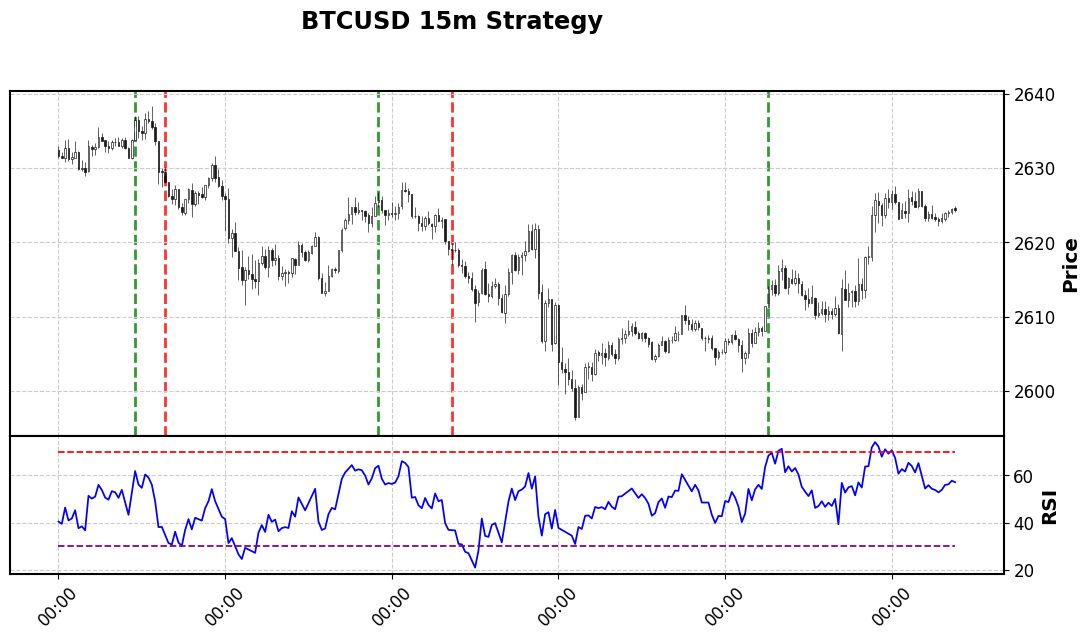

In [ ]:
import mplfinance as mpf
import pandas as pd
import matplotlib.pyplot as plt


class CandlePlotter:
    def __init__(self, data: pd.DataFrame, chart_info: dict):
        """
        data: DataFrame with OHLC and CrossSignal columns (and ideally RSI/SL columns)
        chart_info: dict with config like {"title": "My Chart"}
        """
        self.data = data.copy()
        self.data.index = pd.to_datetime(self.data.index)  # Ensure datetime index
        self.chart_info = chart_info

    def plot(self, show_rsi: bool = True, show_sl: bool = True):
        """Plot candlestick chart with CrossSignal lines, SL levels, and optional RSI subplot."""

        addplots = []

        # === RSI Subplot ===
        if show_rsi and "RSI" in self.data.columns:
            addplots.append(
                mpf.make_addplot(
                    self.data["RSI"],
                    panel=1,              # plot on 2nd panel
                    color="blue",
                    ylabel="RSI"
                )
            )
            # Overbought / oversold levels
            addplots.append(mpf.make_addplot([70] * len(self.data), panel=1, color="red", linestyle="--"))
            addplots.append(mpf.make_addplot([30] * len(self.data), panel=1, color="purple", linestyle="--"))

        # === SL Horizontal Line ===
        if show_sl and "SL" in self.data.columns:
            addplots.append(
                mpf.make_addplot(
                    self.data["SL"],
                    panel=0,     # same as candlestick panel
                    color="orange",
                    linestyle="--",
                    width=1,
                    alpha=0.8,
                )
            )

        # === Candlestick Plot ===
        fig, axes = mpf.plot(
            self.data,
            type='candle',
            style='classic',
            volume=False,
            figratio=(14, 7),
            figscale=1.2,
            returnfig=True,
            title=self.chart_info.get("title", "Candlestick Chart"),
            addplot=addplots
        )

        # === CrossSignal Vertical Markers ===
        if "CrossSignal" in self.data.columns:
            for i, signal in enumerate(self.data["CrossSignal"]):
                if signal == -1:
                    axes[0].axvline(x=i, color="red", linestyle="--", alpha=0.8, zorder=0)
                elif signal == 1:
                    axes[0].axvline(x=i, color="green", linestyle="--", alpha=0.8, zorder=0)

        plt.show()


# --- Example Usage ---
Chartinfos = {"title": "BTCUSD 15m Strategy"}
plotter = CandlePlotter(plot_data, Chartinfos)
plotter.plot(show_rsi=True, show_sl=True)


In [16]:
# Add SL column: current candle's Low
plot_data['SL'] = plot_data['Low']
plot_data['ENTRY'] = plot_data['Low']

# Add TP column: Close price 3 candles ahead
plot_data['TP'] = plot_data['Close'].shift(-3)

# Show the updated table
plot_data.tail(5)


,DateTime,Open,High,Low,Close,Volume,RSI,RSI_EMA21,EMA21,EMA51,Diff,CrossSignal,SL,ENTRY,TP
295,2024-12-31 20:45:00,2622.889,2623.982,2622.633,2623.216,1215,53.886042,59.013076,2622.862966,2618.997965,3.865000,0.0,2622.633,2622.633,2624.526
296,2024-12-31 21:00:00,2623.181,2624.128,2622.898,2623.950,573,56.016907,58.740697,2622.961787,2619.188428,3.773359,0.0,2622.898,2622.898,2624.381
297,2024-12-31 21:15:00,2624.003,2624.336,2623.478,2624.023,414,56.233516,58.512771,2623.058261,2619.374373,3.683888,0.0,2623.478,2623.478,NaN
298,2024-12-31 21:30:00,2624.028,2624.677,2623.825,2624.526,340,57.776547,58.445842,2623.191692,2619.572513,3.619179,0.0,2623.825,2623.825,NaN
299,2024-12-31 21:45:00,2624.570,2624.925,2624.043,2624.381,580,57.151027,58.328131,2623.299811,2619.757455,3.542356,0.0,2624.043,2624.043,NaN


In [17]:
# plot_data.to_csv('15MIN-Updated.csv', index=False)